   Day  Satisfaction Score  Dynamic Price (SGD)  Possible Extra Revenue (SGD)
0    1               10.96                64.98                     4240.4208
1    2               10.70                64.85                     3548.9625
2    3                0.00                59.50                       62.0000
3    4               11.00                65.00                     4350.0000
4    5                8.16                63.58                        0.0000
Days with price below 62 SGD: 28 (28.00%)
Days with price above 62 SGD: 68 (68.00%)
Price distribution for each range:
Price Range
[59.0, 60.0)    24
[60.0, 61.0)     4
[61.0, 62.0)     4
[62.0, 63.0)     0
[63.0, 64.0)     5
[64.0, 65.0)    56
[65.0, 66.0)     7
Name: count, dtype: int64


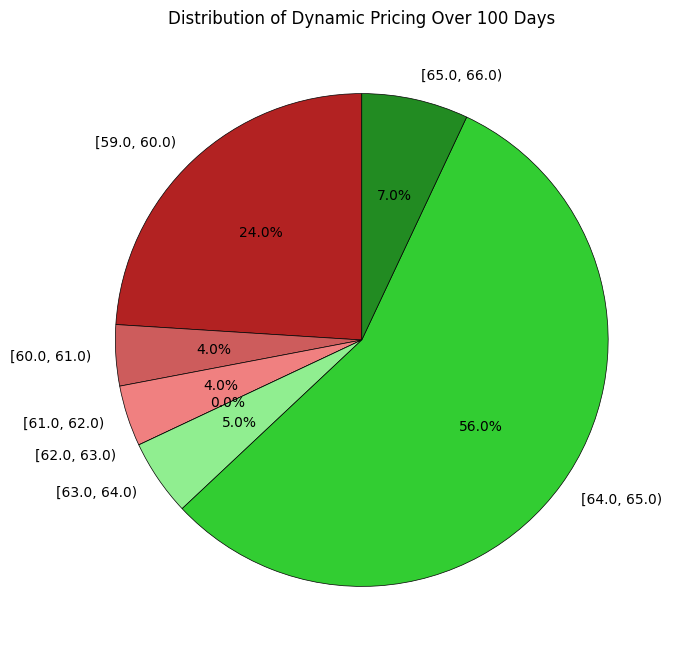

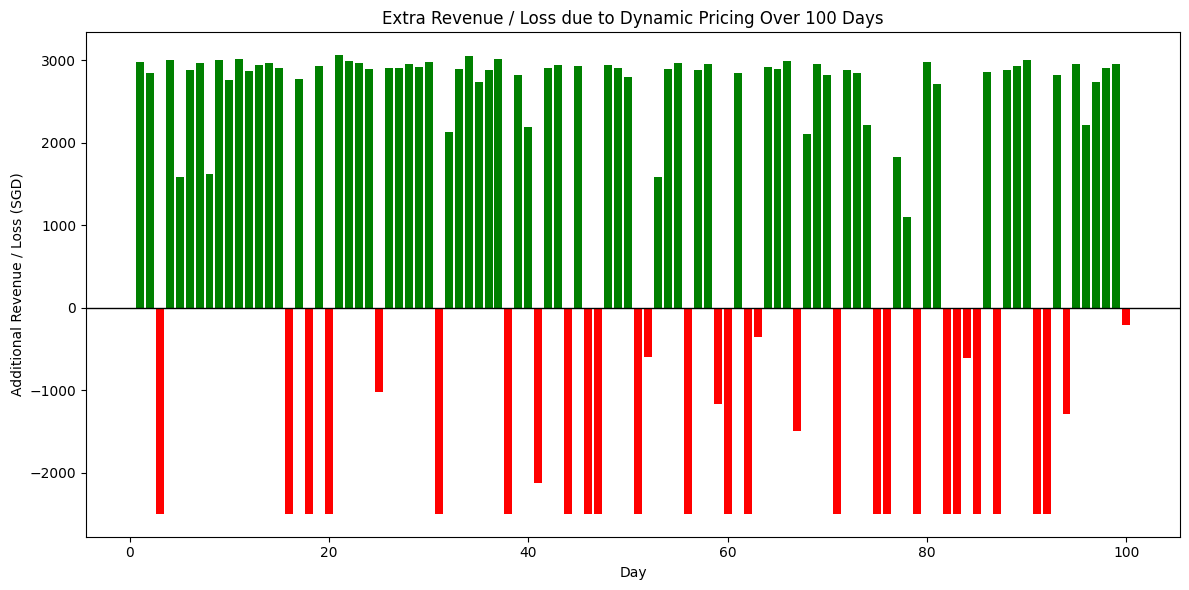

Total Additional Revenue (or Loss) from Dynamic Pricing: SGD 120,980.00
Average Additional Revenue per Day: SGD 1,209.80


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

# Load and preprocess data (already done in previous steps)
data = pd.read_csv('../../Group B/data/daily_weather_data.csv' )
data.replace({'-': np.nan}, inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')
data.fillna(data.median(), inplace=True)
data.drop(columns=['Station'], inplace=True)  # Drop irrelevant columns

# Convert to numeric and handle missing values
data['Year'] = data['Year'].astype(int)
data['Month'] = data['Month'].astype(int)
data['Day'] = data['Day'].astype(int)

# Satisfaction Score Calculation based on weather conditions
def calculate_satisfaction(row):
    satisfaction_score = 5
    # Categorize the day (sunny, rainy, or shower)
    if row['Highest 60 min Rainfall (mm)'] > row['Highest 30 min Rainfall (mm)']:
        day_type = 'rainy'
    elif row['Highest 30 min Rainfall (mm)'] == row['Highest 60 min Rainfall (mm)']:
        day_type = 'shower'
    else:
        day_type = 'sunny'
    
    # Sunny days: Cooler days are better for satisfaction
    if day_type == 'sunny':
        satisfaction_score -= row['Mean Temperature (°C)'] * 0.6

    # Rainy days: Rainy days have lower satisfaction, more rain means worse satisfaction
    elif day_type == 'rainy':
        satisfaction_score -= row['Daily Rainfall Total (mm)'] * 0.6
        satisfaction_score -= row['Highest 30 min Rainfall (mm)'] * 0.3

    # Shower days: Mildly affected by rain, and temperature matters too
    elif day_type == 'shower':
        satisfaction_score -= row['Highest 30 min Rainfall (mm)'] * 0.4
        satisfaction_score += row['Mean Temperature (°C)'] * 0.2

    # Wind Speed: If max wind exceeds thresholds, it reduces satisfaction
    if row['Max Wind Speed (km/h)'] > 60:
        satisfaction_score -= 5  # Very high winds, all outdoor rides closed
    elif row['Max Wind Speed (km/h)'] > 40:
        satisfaction_score -= 3  # High winds, outdoor rides affected

    # Clamp the satisfaction score to a reasonable range (0-100)
    satisfaction_score = max(min(satisfaction_score, 100), 0)

    return satisfaction_score

# Apply the function to the dataframe
data['Satisfaction Score'] = data.apply(calculate_satisfaction, axis=1)

# Dynamic Pricing Calculation
def dynamic_pricing(satisfaction_score):
    """
    Adjust the ticket price based on the satisfaction score.
    Higher satisfaction: Higher price.
    Lower satisfaction: Lower price.
    The price is centered around 62 SGD.
    """
    base_price = 62  # Base ticket price in SGD (fixed)
    
    # Increase the price adjustment factor to ensure a broader price range
    price_adjustment_factor = (satisfaction_score - 5) * 0.5  # 0.5 SGD per point of satisfaction    
    final_price = base_price + price_adjustment_factor
    
    # Ensure that the price doesn't go below 30 SGD or above a reasonable upper limit (e.g., 100 SGD)
    final_price = max(min(final_price, 100), 30)
    
    return final_price


# Simulating the dynamic pricing system for 100 days
days_to_simulate = 100
simulated_revenue = []
simulated_satisfaction = []
simulated_prices = []
random.seed(3101)

# Simulating guest behavior: Assuming guests are more likely to visit if the price is low and satisfaction is high
def simulate_guests(price, satisfaction_score):
    base_visits = 1000  # Assume a base number of visitors for a day
    price_sensitivity = 0.5  # Price sensitivity factor
    satisfaction_sensitivity = 0.1  # Satisfaction sensitivity factor

    # Simulate the number of visitors based on price and satisfaction
    adjusted_visits = base_visits * (1 - price_sensitivity * (price - 62)) * (1 + satisfaction_sensitivity * (satisfaction_score - 50))
    return max(adjusted_visits, 0)

# Simulating for each day over 100 days
for i in range(days_to_simulate):
    # Select a random day's data (simulate random weather)
    day_data = data.iloc[random.randint(0, len(data) - 1)]
    
    # Get satisfaction score and dynamic price for the day
    satisfaction_score = day_data['Satisfaction Score']
    price = dynamic_pricing(satisfaction_score)
    
    # Simulate guest behavior (number of visitors)
    num_visitors = simulate_guests(price, satisfaction_score)
    
    # Calculate daily revenue
    if price >= 62:
        revenue = (price - 62) * num_visitors
    else:
        revenue = 62
    
    # Record the results for analysis
    simulated_revenue.append(revenue)
    simulated_satisfaction.append(satisfaction_score)
    simulated_prices.append(price)

# Create a DataFrame with the simulation results
simulation_results = pd.DataFrame({
    'Day': range(1, days_to_simulate + 1),
    'Satisfaction Score': simulated_satisfaction,
    'Dynamic Price (SGD)': simulated_prices,
    'Possible Extra Revenue (SGD)': simulated_revenue
})

# Step 6: Analyze Results
print(simulation_results.head())

# --- Price Distribution Analysis ---
# Get the minimum and maximum dynamic prices from the simulation data
min_price = simulation_results['Dynamic Price (SGD)'].min()
max_price = simulation_results['Dynamic Price (SGD)'].max()

# Create price bins based on whole dollar intervals
price_bins = np.arange(np.floor(min_price), np.ceil(max_price) + 1, 1)  # Whole dollar intervals

# Categorize the dynamic prices into these bins
simulation_results['Price Range'] = pd.cut(simulation_results['Dynamic Price (SGD)'], bins=price_bins, right=False, include_lowest=True)

# Count the number of days in each price range
price_range_counts = simulation_results['Price Range'].value_counts().sort_index()

# Calculate percentage of days with prices above and below 62
below_62_count = price_range_counts[price_range_counts.index.to_series().apply(lambda x: x.right < 62)].sum()
above_62_count = price_range_counts[price_range_counts.index.to_series().apply(lambda x: x.left >= 62)].sum()

# Calculate the total number of days simulated
total_days = len(simulation_results)

# Percentage of days below and above 62 SGD
below_62_percentage = (below_62_count / total_days) * 100
above_62_percentage = (above_62_count / total_days) * 100

# Print the distribution analysis
print(f"Days with price below 62 SGD: {below_62_count} ({below_62_percentage:.2f}%)")
print(f"Days with price above 62 SGD: {above_62_count} ({above_62_percentage:.2f}%)")

# Print the price distribution by range
print(f"Price distribution for each range:\n{price_range_counts}")

# --- Pie Chart for Price Distribution ---
# Get color mapping based on price bins
def get_color(value):
    """
    Assign colors based on price ranges using CSS4 color names.
    """
    if 61.0 <= value < 62.0 or 62.0 <= value < 63.0:
        return 'lightcoral'  # [61.0, 62.0) and [62.0, 63.0)
    elif 60.0 <= value < 61.0:
        return 'indianred'  # [60.0, 61.0)
    elif 59.0 <= value < 60.0:
        return 'firebrick'  # [59.0, 60.0)
    elif 63.0 <= value < 64.0:
        return 'lightgreen'  # [63.0, 64.0)
    elif 64.0 <= value < 65.0:
        return 'limegreen'  # [64.0, 65.0)
    elif 65.0 <= value < 66.0:
        return 'forestgreen'  # [65.0, 66.0)
    else:
        return 'gray'  # Default color for other ranges (optional)

# Apply color map based on price being in the specified ranges
colors = [get_color(val.mid) for val in price_range_counts.index]

# Plot Pie Chart showing the distribution of days across price ranges
plt.figure(figsize=(8, 8))
plt.pie(price_range_counts, labels=price_range_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})  # Thinner outline with linewidth=0.5
plt.title('Distribution of Dynamic Pricing Over 100 Days')



# --- Calculate Baseline Revenue ---
# Baseline revenue assuming the fixed price of 62 SGD per visitor
baseline_revenue = 62 * simulation_results['Possible Extra Revenue (SGD)'].apply(lambda x: simulate_guests(62, 50))

# --- Calculate Dynamic Revenue ---
# Dynamic revenue assuming the dynamic prices and the number of visitors
dynamic_revenue = simulation_results['Dynamic Price (SGD)'] * simulation_results['Possible Extra Revenue (SGD)'].apply(lambda x: simulate_guests(62, 50))

# --- Calculate Extra Revenue or Loss ---
# Extra revenue is the difference between dynamic revenue and baseline revenue
extra_revenue_or_loss = dynamic_revenue - baseline_revenue

# --- Plotting the Bar Plot ---
plt.figure(figsize=(12, 6))

# Create a bar plot with extra revenue above x-axis (green) and loss below x-axis (red)
bars = plt.bar(simulation_results['Day'], extra_revenue_or_loss, 
               color=['green' if x > 0 else 'red' for x in extra_revenue_or_loss])

# Adding labels and titles
plt.axhline(0, color='black', linewidth=1)  # x-axis line
plt.xlabel('Day')
plt.ylabel('Additional Revenue / Loss (SGD)')
plt.title('Extra Revenue / Loss due to Dynamic Pricing Over 100 Days')

# --- Total Effect on Revenue ---
total_effect = extra_revenue_or_loss.sum()

# Show the plot
plt.tight_layout()
plt.show()

# Display the total effect on revenue
print(f"Total Additional Revenue (or Loss) from Dynamic Pricing: SGD {total_effect:,.2f}")
print(f"Average Additional Revenue per Day: SGD {extra_revenue_or_loss.mean():,.2f}")